In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import re
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from rich import print
from tqdm import tqdm

In [2]:
def read_file_to_str_li(fp, print_exp=True):
    with open(fp, "r") as f:
        lines = f.read().split("\n")
    if print_exp:
        print(f"Read from {fp}:")
        print(f"First line: {lines[0]} | Last line: {lines[-1]}")
        print("-" * 6)

    return lines


# define the function blocks
def convert_to_int(input_str):
    if input_str == "" or input_str == " ":
        return None
    return int(input_str)


def convert_to_str(input_str):
    return str(input_str)


# map the inputs to the function blocks
converts = {
    "i": convert_to_int,
    "s": convert_to_str,
}


def convert_str_li_to_other_li(
    str_li, pattern="i", per_letter=False, sep=" ", start_row=0, end_row=None
):
    """ Convert a list of string to a list of other types
    
    pattern: a list of types for one item. 
        'i' for int, 's' for string
        'si' means: convert the 1st item to string, the rest to integer
        If separated items are more than pattern items,
        use the last one from the parttern.
    if per_letter=True, ignore sep and separate item per letter
    """
    target_str_li = str_li[start_row:end_row]
    # find max item num
    max_item_num = 1
    if per_letter:
        max_item_num = max([len(s) for s in target_str_li])
    else:
        max_item_num = max([len(s.split(sep)) for s in target_str_li])

    # extend the pattern to the max itme num
    pattern = (
        pattern + f"{pattern[-1]}" * (max_item_num - len(pattern))
        if max_item_num > len(pattern)
        else pattern
    )

    # convert
    if per_letter:
        return [
            [converts[pattern[idx]](item) for idx, item in enumerate(s)]
            for s in target_str_li
        ]
    else:
        if sep == " ":
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split())]
                for s in target_str_li
            ]
        else:
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split(sep))]
                for s in target_str_li
            ]

In [3]:
fp = "input.txt"
lines = read_file_to_str_li(fp)

print("Convert to:")

# head = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=",", start_row=0, end_row=1
# )

# print(f"Head:\n{head}")

data = convert_str_li_to_other_li(
    lines, pattern="i", per_letter=True, sep=" ", start_row=None, end_row=None
)

# data = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=False, sep=" | ", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=",", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=False, sep=" -> ", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=" ", start_row=2, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="si", per_letter=False, sep=" ", start_row=0, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=True, sep=" ", start_row=0, end_row=None
# )

print(f"First line: {data[0]}")
print(f"Last line: {data[-1]}")
print("-" * 6)

Read from input.txt:

First line: 019876545679349876566789989543232345989545789988678987679865676789019898932399765
4321296543219876545 | Last line: 678999898967891235691398765432987432101469876543210156893201
2489345789997654123456789994323434893213

------

Convert to:

First line: [0, 1, 9, 8, 7, 6, 5, 4, 5, 6, 7, 9, 3, 4, 9, 8, 7, 6, 5, 6, 6, 7, 8, 9, 9, 8, 9,
5, 4, 3, 2, 3, 2, 3, 4, 5, 9, 8, 9, 5, 4, 5, 7, 8, 9, 9, 8, 8, 6, 7, 8, 9, 8, 7, 6, 7, 9, 8, 
6, 5, 6, 7, 6, 7, 8, 9, 0, 1, 9, 8, 9, 8, 9, 3, 2, 3, 9, 9, 7, 6, 5, 4, 3, 2, 1, 2, 9, 6, 5, 
4, 3, 2, 1, 9, 8, 7, 6, 5, 4, 5]

Last line: [6, 7, 8, 9, 9, 9, 8, 9, 8, 9, 6, 7, 8, 9, 1, 2, 3, 5, 6, 9, 1, 3, 9, 8, 7, 6, 5, 
4, 3, 2, 9, 8, 7, 4, 3, 2, 1, 0, 1, 4, 6, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 5, 6, 8, 9, 3, 2, 
0, 1, 2, 4, 8, 9, 3, 4, 5, 7, 8, 9, 9, 9, 7, 6, 5, 4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 4, 3, 
2, 3, 4, 3, 4, 8, 9, 3, 2, 1, 3]

------

In [4]:
heightmap = np.array(data)

heightmap_pad = np.pad(heightmap, pad_width=1, constant_values=10)

down = np.roll(heightmap_pad, 1, axis=0)
up = np.roll(heightmap_pad, -1, axis=0)
right = np.roll(heightmap_pad, 1, axis=1)
left = np.roll(heightmap_pad, -1, axis=1)

low_map_pad = (
    (down > heightmap_pad)
    & (up > heightmap_pad)
    & (right > heightmap_pad)
    & (left > heightmap_pad)
)

low_map = low_map_pad[1:-1, 1:-1]

print(f"Answer to Q1: {heightmap[low_map].sum() + low_map.sum()}")

Answer to Q1: 526

In [17]:
def find_basin_size(low_map_pad):
    count = low_map_pad.sum()
    while True:
        low_map_pad |= (
            (down < heightmap_pad)
            & (np.roll(low_map_pad, 1, axis=0))
            & (heightmap_pad < 9)
        )
        low_map_pad |= (
            (up < heightmap_pad)
            & (np.roll(low_map_pad, -1, axis=0))
            & (heightmap_pad < 9)
        )
        low_map_pad |= (
            (right < heightmap_pad)
            & (np.roll(low_map_pad, 1, axis=1))
            & (heightmap_pad < 9)
        )
        low_map_pad |= (
            (left < heightmap_pad)
            & (np.roll(low_map_pad, -1, axis=1))
            & (heightmap_pad < 9)
        )
        if low_map_pad.sum() == count:
            break
        else:
            count = low_map_pad.sum()
    return count

basin_sizes = []
store_basin = []
for i in range(low_map.shape[0]):
    for j in range(low_map.shape[1]):
        if low_map[i, j]:
            low_map_pad = np.zeros_like(low_map_pad)
            low_map_pad[i + 1, j + 1] = True
            basin_sizes.append(find_basin_size(low_map_pad))
            store_basin.append(low_map_pad[1:-1, 1:-1])

basin_sizes_sorted = np.sort(basin_sizes)

print(f"Answer to Q2: {basin_sizes_sorted[-1] * basin_sizes_sorted[-2] * basin_sizes_sorted[-3]}")

Answer to Q2: 1123524

In [30]:
import matplotlib.pyplot as plt
def show_basin(low_map_pad,title):
    plt.imshow(low_map_pad.astype('int'), interpolation='none')
    plt.axis('off')
    plt.title(title)
    plt.show()

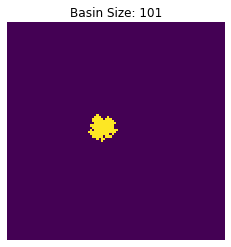

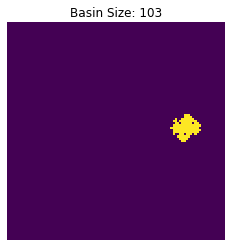

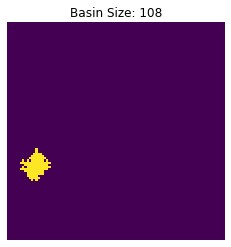

In [32]:
top_k = np.argpartition(basin_sizes, -3)[-3:]
for i in top_k:
    show_basin(store_basin[i], f"Basin Size: {basin_sizes[i]}")

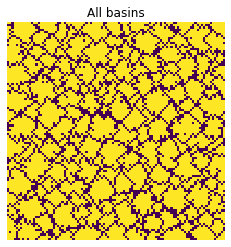

In [36]:
all_basins = np.any(store_basin,axis=0)
show_basin(all_basins, f"All basins")